In [1]:
# block 1: import all important libraries

%reset
%matplotlib inline
from netCDF4 import Dataset
from netCDF4 import num2date
from matplotlib.pyplot import figure, pcolor, colorbar, xlabel, ylabel, title, draw, quiver, show
import numpy as np
import matplotlib.pyplot as plt 
import scipy.io as sio
import pandas as pd
import numpy.ma as ma
from math import sqrt 
import matplotlib.dates as mdates

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
# block 2: Import the used data file and create a variable with the data in the file

data = "/home/z3525831/Python script/EAC_2/IMOS_ABOS-DA_AETVZ_20120422T070000Z_EAC2_FV01_EAC2-2012-WORKHORSE-ADCP-81_END-20130824T043000Z_C-20141016T011317Z.nc"
ADCP400 = Dataset(data)

In [3]:
# block 3: Extracting the U/V/time/H_B_S/qc data from the import file and assigns them to a variable

TIMES = ADCP400.variables['TIME']
DEPTH = ADCP400.variables['DEPTH']
V = ADCP400.variables['VCUR']
U = ADCP400.variables['UCUR']
W = ADCP400.variables['WCUR']
Wheight = ADCP400.variables['HEIGHT_ABOVE_SENSOR']


#quality control
hasqc = ADCP400.variables['HEIGHT_ABOVE_SENSOR_quality_control']
Vqc = ADCP400.variables['VCUR_quality_control']
Uqc = ADCP400.variables['UCUR_quality_control']
Dqc = ADCP400.variables['DEPTH_quality_control']
tqc = ADCP400.variables['TIME_quality_control']

# To regrid for Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))             
Depth_i = 0                              
Depth_f = 250                              
Depth_dz = 5 

In [4]:
#block 4: Convert the ADCP time series dataset (Matlab to python time series: yyyy/mm/DD hh/mm/SS)

units = ADCP400.variables['TIME'].units
calendar = ADCP400.variables['TIME'].calendar
times = num2date(ADCP400.variables['TIME'][:], units=units, calendar=calendar)
times1 = mdates.date2num(times)

In [5]:
#block 5: Create variables with ADCP dataset 

#basic data
depth_ADCP = DEPTH[:,0,0]
depth_Bin = Wheight[:]   
data_u = U [:,:,:,:]
data_v = V [:,:,:,:]
v2d = data_v[:,:,0,0]
u2d = data_u[:,:,0,0]

#quality controle data 
hasqc1 = hasqc[:]
Vqc1 = Vqc[:,:,0,0]
Uqc1 = Uqc[:,:,0,0]
Dqc1 = Dqc[:,0,0]

In [6]:
#block 4: Use the quality control data for clean the wrong values (wrong values = Nan)

depth_ADCP[Dqc1 != 1] = np.NaN 
Vqc2 = v2d
Vqc2[Vqc1 != 1] = np.NaN
Uqc2 = u2d
Uqc2[Uqc1 != 1] = np.NaN

In [7]:
#block 5: reshape the depth of the mooring and the depth above the sensor for having the same shape.

depth_ADCP14=np.transpose(np.kron(np.ones((len(Wheight),1)),depth_ADCP)) # repeated the dph 14 times to match size of v2d.
depth_ADCP14[depth_ADCP14 < 10] = np.NaN                       # delete bad qc when depth instrument < 10m
depth_Bin_gridded=np.kron(np.ones((len(times1),1)),depth_Bin)

/home/z3525831/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in less
  after removing the cwd from sys.path.


In [8]:
#block 6: Create the real depth variable.

DepthReal = depth_ADCP14-depth_Bin_gridded

In [9]:
#block 7: Create the good time and depth variable for the scatter plot.

Times_final = np.transpose(np.kron(np.ones((len(Wheight),1)),times1))

In [10]:
#V

In [11]:
# block 8: Use loop "for", for interpolate the new V variables with the new depth grid                              

#create the new variable Depth and V for assigned the result of the loop
Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))                               
V_interp_final = np.NaN + np.zeros((len(times1),len(Depth_interp_final)))

# Start the loop
# Use vector for time t
for t in range(len(Times_final)):  

    to_Vqc2_interp = np.NaN + np.zeros(len(Depth_interp_final))
    V_for_loop  = np.NaN + np.zeros(len(depth_Bin))
    Depth_For_loop  = np.NaN + np.zeros(len(depth_Bin))
    V_for_loop = Vqc2[t,:]
    Depth_For_loop = DepthReal[t,:]

#create the good shape for the final depth, use the loop for variables with not only Nan values.
#    print(Depth_interp_final)
    ind, = np.where(~np.isnan(V_for_loop))    
    if ~np.isnan(V_for_loop).all():
        to_Vqc2_interp = np.interp(-Depth_interp_final,-Depth_For_loop[ind],V_for_loop[ind],left=np.NaN,right=np.NaN)
    V_interp_final[t,] = to_Vqc2_interp
# OR IF USE APPEND:     V_interp_final = np.append(V_interp_final, [to_Vqc2_interp], axis=0)

# Mask to be able to plot:
V_interp_final_ma = np.ma.array (V_interp_final, mask=np.isnan(V_interp_final))

### Check
#plt.figure(figsize=(15,10))
#for t in range(0,len(Times_final),100):  
    #V_for_loop = Vqc2[t,:]
    #Depth_For_loop = DepthReal[t,:]
    #plt.plot(V_for_loop,Depth_For_loop,'ko-')
    #plt.plot(V_interp_final[t,:],Depth_interp_final,'bo-')

In [12]:
np.nanmean(V_interp_final_ma)

-0.7138129831575702

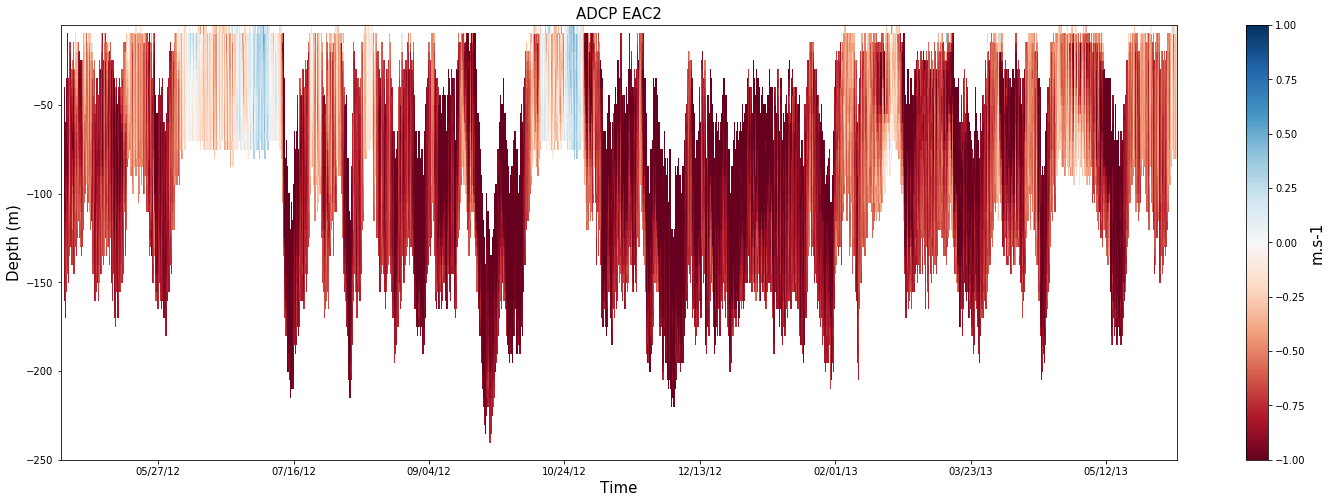

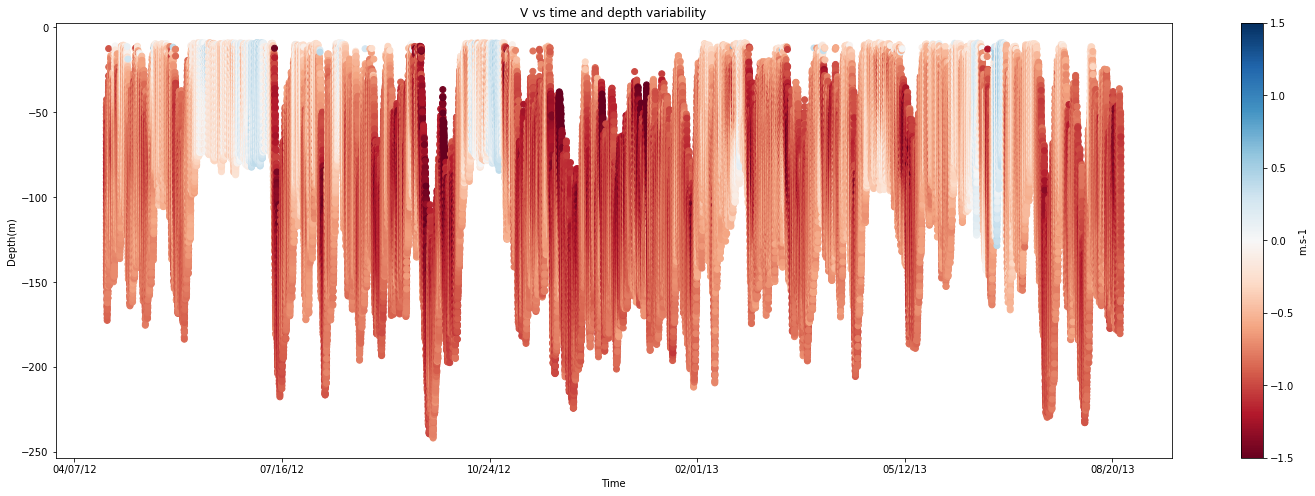

In [13]:
#block 9: Plot V vs time and depth

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times1,-Depth_interp_final,np.transpose(V_interp_final_ma),cmap='RdBu')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time",fontsize=15) 
plt.xlim(734614.0,735026.0)
plt.ylabel("Depth (m)",fontsize=15)
plt.title("ADCP EAC2",fontsize=15)
clb = plt.colorbar()
clb.set_label('m.s-1',fontsize=15)
plt.clim(-1, 1)
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Vqc2, cmap='RdBu')
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("V vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.clim(-1.5, 1.5)
plt.show()

In [14]:
times1

array([734613.29758461, 734613.33925127, 734613.38091794, ...,
       735108.04758461, 735108.08925127, 735108.13091794])

In [15]:
# block 10: Use loop "for", for interpolat the U variables with the new depth grid                              

#create the new variable Depth and V for assigned the result of the loop
Depth_interp_final = (np.arange(Depth_f,Depth_i,-Depth_dz))                               # New depth grid
U_interp_final = np.NaN + np.zeros((len(times1),len(Depth_interp_final)))


# Start the loop
# Use vector for time t
for t in range(len(Times_final)):  

    to_Uqc2_interp = np.NaN + np.zeros(len(Depth_interp_final))
    U_for_loop  = np.NaN + np.zeros(len(depth_Bin))
    Depth_For_loop  = np.NaN + np.zeros(len(depth_Bin))
    U_for_loop = Uqc2[t,:]
    Depth_For_loop = DepthReal[t,:]

#create the good shape for the final depth, use the loop for variables with not only Nan values.
#    print(Depth_interp_final)
    ind, = np.where(~np.isnan(U_for_loop))    
    if ~np.isnan(U_for_loop).all():
        to_Uqc2_interp = np.interp(-Depth_interp_final,-Depth_For_loop[ind],U_for_loop[ind],left=np.NaN,right=np.NaN)
    U_interp_final[t,] = to_Uqc2_interp
# OR IF USE APPEND:     V_interp_final = np.append(V_interp_final, [to_Vqc2_interp], axis=0)

# Mask to be able to plot:
U_interp_final_ma = np.ma.array (U_interp_final, mask=np.isnan(U_interp_final))

# Check
#plt.figure(figsize=(15,10))
#for t in range(0,len(Times_final),100):  
    #U_for_loop = Uqc2[t,:]
    #Depth_For_loop = DepthReal[t,:]
    #plt.plot(U_for_loop,Depth_For_loop,'ko-')
    #plt.plot(U_interp_final[t,:],Depth_interp_final,'bo-')

In [16]:
#block 12: Create basic speed 

Speed = (Uqc2*Uqc2) + (Vqc2*Vqc2)
Speedf = np.sqrt(Speed)

In [17]:
#block 13: Create interpolate speed 

#rename U and V variables for the speed equation
U_interp_sp = np.transpose(U_interp_final_ma)
V_interp_sp = np.transpose(V_interp_final_ma)


Speed_interp = (U_interp_sp*U_interp_sp) + (V_interp_sp*V_interp_sp)
Speed_interp_final = np.sqrt(Speed_interp)

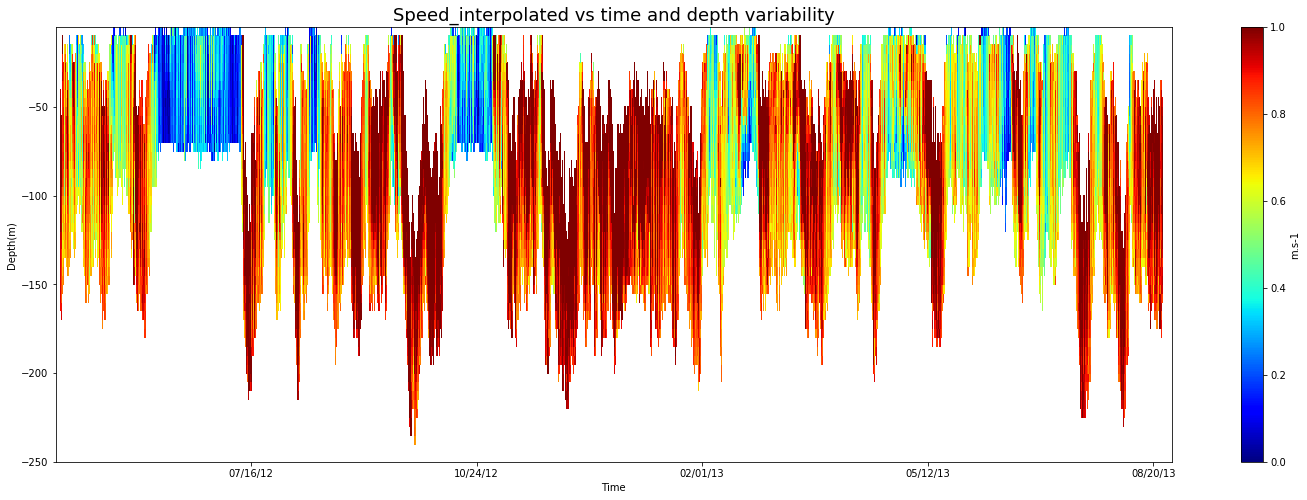

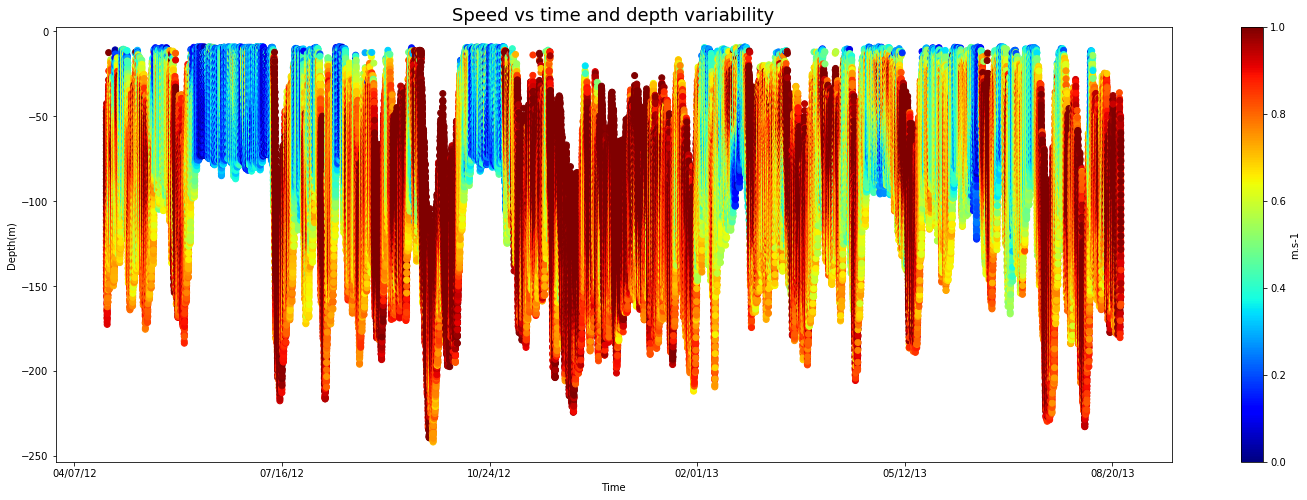

In [18]:
#block 14: Plot basic speed and interpolate speed vs time and depth

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times1,-Depth_interp_final,Speed_interp_final,cmap='jet',vmin=0,vmax=1)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Speed_interpolated vs time and depth variability",fontsize=18)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()


fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Speedf, cmap='jet',vmin=0,vmax=1)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Speed vs time and depth variability",fontsize=18)
plt.show()

In [19]:
#block 15: Create basic power density

P = 0.5 * 1025* (Speedf**3)     
Pf = P/1000

In [20]:
#block 16: Create interpolate power density

Power_interpolation = 0.5 * 1025* (Speed_interp_final**3)     
Power_interplation_final = Power_interpolation/1000 # convert unit in kW

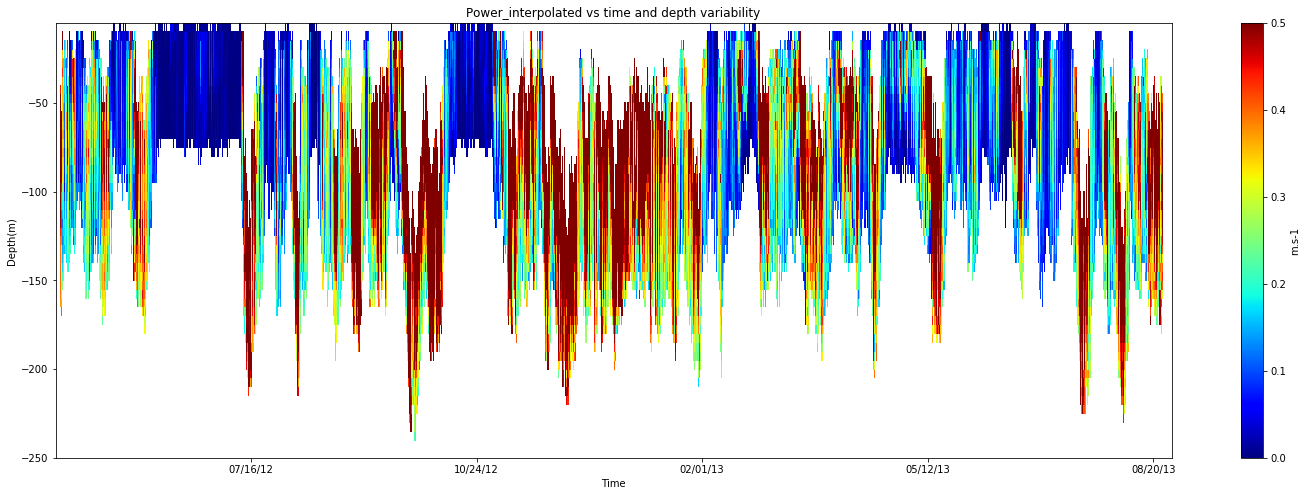

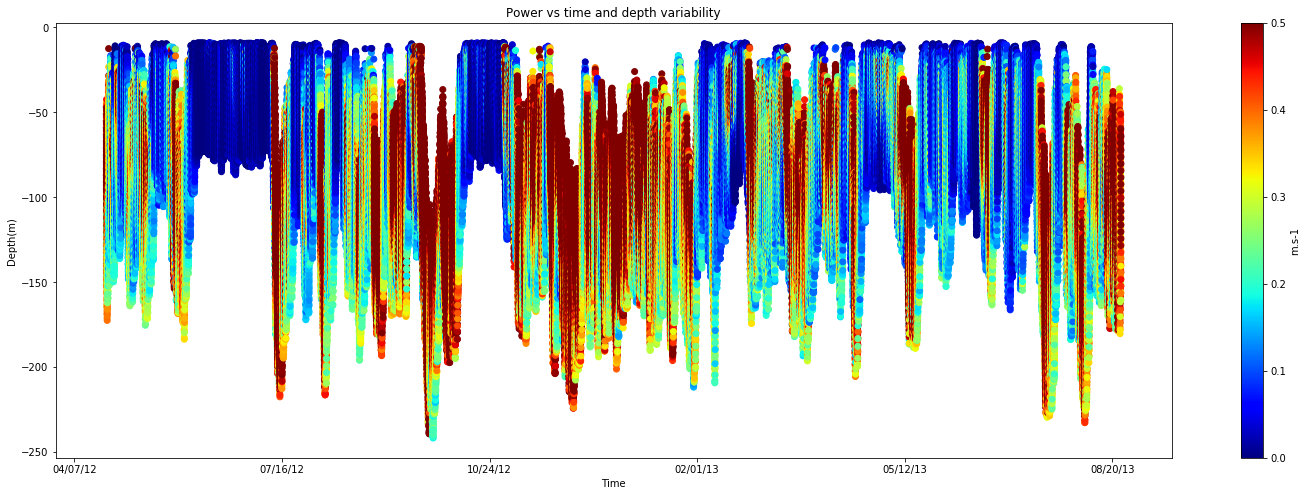

In [21]:
#block 17: Plot basic power density and interpolate power density vs time and depth

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.pcolor(times1,-Depth_interp_final,Power_interplation_final,cmap='jet',vmin=0,vmax=0.5)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Power_interpolated vs time and depth variability")
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.show()

fig, ax = plt.subplots(1,1,figsize=(25,8))
plt.scatter(Times_final, -DepthReal, c=Pf, cmap='jet',vmin=0,vmax=0.5)
date_format = mdates.DateFormatter('%D')
ax.xaxis.set_major_formatter(date_format)
clb = plt.colorbar()
clb.set_label('m.s-1')
plt.xlabel("Time") 
plt.ylabel("Depth(m)")
plt.title("Power vs time and depth variability")
plt.show()

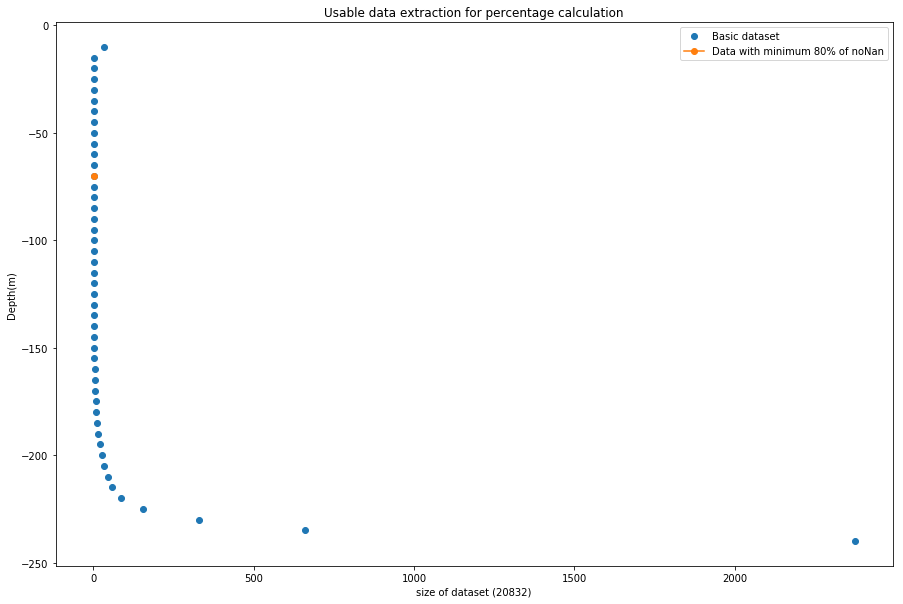

In [22]:
#block 18: use a "for" loop to calculate the percentage of power density interpolate above 0.5kW/m2 vs time and depth
#only noNan used

# Percentage of good data (no nan) for each depth
Depth_NoNans = ma.count(Power_interplation_final, axis=1)   # count non masks
Depth_Pourcentage_NoNans = ma.count(Power_interplation_final, axis=1)/len(times)*100   # count non masks percentage

P_pourcentage_final = np.NaN + np.zeros(len(Depth_interp_final))
for z in range(len(Depth_interp_final)): 
    #print(z)
    ind, = np.where(Power_interplation_final[z,:] > 0.5)  # rentability
#    ind, = np.where(Power_interplation_final[z,:] > 0.064)  # rentability
    if Depth_NoNans[z]>0:
        P_pourcentage_final[z] = len(ind)/Depth_NoNans[z]

plt.figure(figsize=(15,10))
plt.plot(P_pourcentage_final,-Depth_interp_final,'o', label="Basic dataset") #plot basic data 
plt.plot(P_pourcentage_final[Depth_Pourcentage_NoNans>80],-Depth_interp_final[Depth_Pourcentage_NoNans>80],'-o', label="Data with minimum 80% of noNan")
plt.xlabel("size of dataset (20832)")             
plt.ylabel("Depth(m)")
plt.title("Usable data extraction for percentage calculation")
plt.legend() 
plt.show()

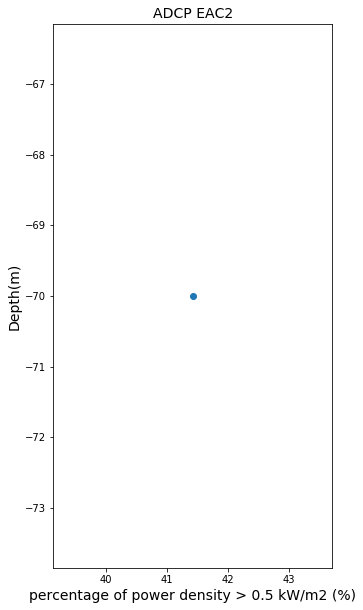

In [26]:
#block 19: Plot the percentage of power density > 0.5 kW/m2 vs depth and time

plt.figure(figsize=(5,10))
plt.plot(P_pourcentage_final[Depth_Pourcentage_NoNans>80]*100,-Depth_interp_final[Depth_Pourcentage_NoNans>80],'-o')
plt.xlabel("percentage of power density > 0.5 kW/m2 (%)",fontsize=14)             
plt.ylabel("Depth(m)",fontsize=14)
#plt.ylim(-90.3,-40)
plt.title("ADCP EAC2",fontsize=14)
plt.show()

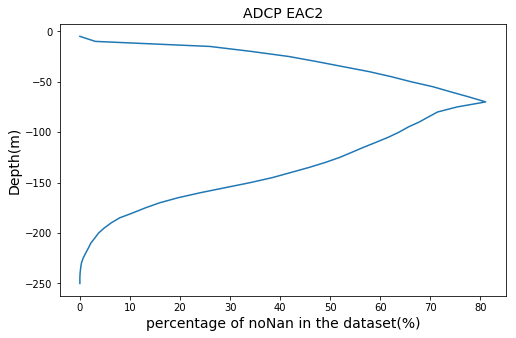

In [24]:
#block 20: Plot the percentage of noNan in the dataset vs depth
plt.figure(figsize=(8,5))
plt.plot(Depth_Pourcentage_NoNans,-Depth_interp_final)
plt.xlabel("percentage of noNan in the dataset(%)",fontsize=14)             
plt.ylabel("Depth(m)",fontsize=14)
plt.title("ADCP EAC2",fontsize=14)
plt.show()

In [57]:
#block 21: use a "for" loop to calculate the basic percentage of power density interpolate above 0.5kW/m2 vs time and depth

P_pourcentage_final = []

Depth_i_test = 20                              
Depth_f_test = 175                              
Depth_dz_test = 5 
Depth_interp_final_test = (np.arange(Depth_f_test,Depth_i_test,-Depth_dz_test))                               


for z in range(len(Depth_interp_final_test)): 
        Depth_Pourcentage = np.where(Power_interplation_final[z,:] > 0.5)         
        Depth_Pourcentage2 = np.array(Depth_Pourcentage)
        #print(np.shape(Depth_Pourcentage2.T))
        P_pourcentage = (len(Depth_Pourcentage2.T)*100)/20832
        P_pourcentage_final.append(P_pourcentage)

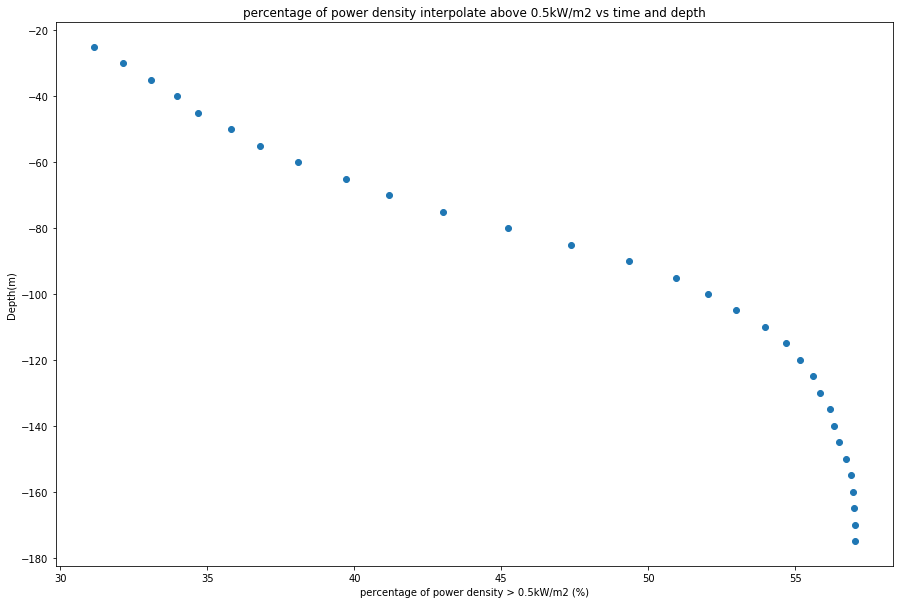

In [58]:
#block 22: PLot the basic percentage of power density interpolate above 0.5kW/m2 vs time and depth

plt.figure(figsize=(15,10))
plt.plot(P_pourcentage_final,-Depth_interp_final_test,'o')
plt.xlabel("percentage of power density > 0.5kW/m2 (%)")             
plt.ylabel("Depth(m)")
plt.title("percentage of power density interpolate above 0.5kW/m2 vs time and depth")
plt.show()

In [59]:
-Depth_interp_final[Depth_Pourcentage_NoNans>80]

array([-70])

In [28]:
np.shape(-Depth_interp_final)

(50,)

In [29]:
-Depth_interp_final[36]

-70

In [30]:
np.shape(Power_interplation_final)

(50, 11877)

In [31]:
np.nanmean(Power_interplation_final[36,:])

0.2827933433386138